# Model with Multilayer Perceptron (MLP) Neural Network

For this model, we choose:

- hidden layer
- accuracy, AUC-ROC, and a confusion matrix as performance metrics

Epoch [1/50], Step [100/429], Loss: 2.8735
Epoch [1/50], Step [200/429], Loss: 2.3370
Epoch [1/50], Step [300/429], Loss: 2.1452
Epoch [1/50], Step [400/429], Loss: 2.0305
Epoch [1/50], Train Accuracy: 47.87%, Test Accuracy: 45.65%
Epoch [2/50], Step [100/429], Loss: 1.5930
Epoch [2/50], Step [200/429], Loss: 1.7946
Epoch [2/50], Step [300/429], Loss: 1.5598
Epoch [2/50], Step [400/429], Loss: 1.4881
Epoch [2/50], Train Accuracy: 60.60%, Test Accuracy: 51.76%
Epoch [3/50], Step [100/429], Loss: 1.2330
Epoch [3/50], Step [200/429], Loss: 1.2217
Epoch [3/50], Step [300/429], Loss: 1.3086
Epoch [3/50], Step [400/429], Loss: 1.2518
Epoch [3/50], Train Accuracy: 66.22%, Test Accuracy: 56.57%
Epoch [4/50], Step [100/429], Loss: 1.0205
Epoch [4/50], Step [200/429], Loss: 0.7974
Epoch [4/50], Step [300/429], Loss: 1.0637
Epoch [4/50], Step [400/429], Loss: 1.1341
Epoch [4/50], Train Accuracy: 69.70%, Test Accuracy: 60.58%
Epoch [5/50], Step [100/429], Loss: 1.0250
Epoch [5/50], Step [200/429],

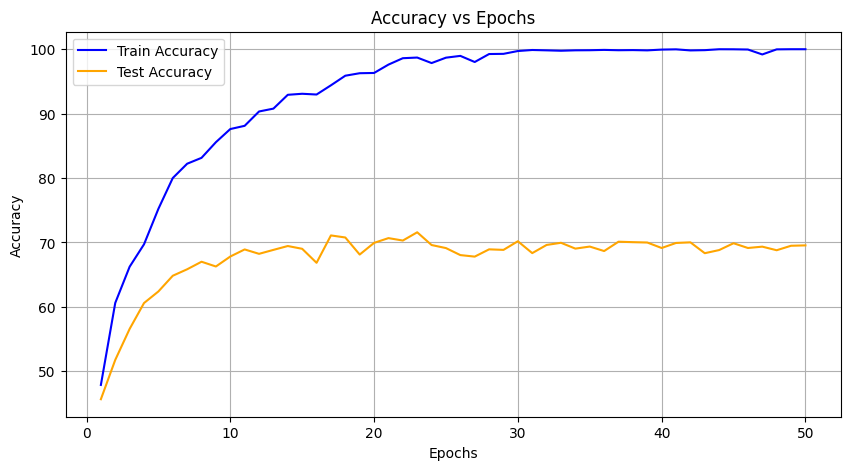

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Shape of y_score: (7172, 24)
AUC-ROC: 0.9710948559560371
Accuracy of the network on the test images: 69.53430005577245 %


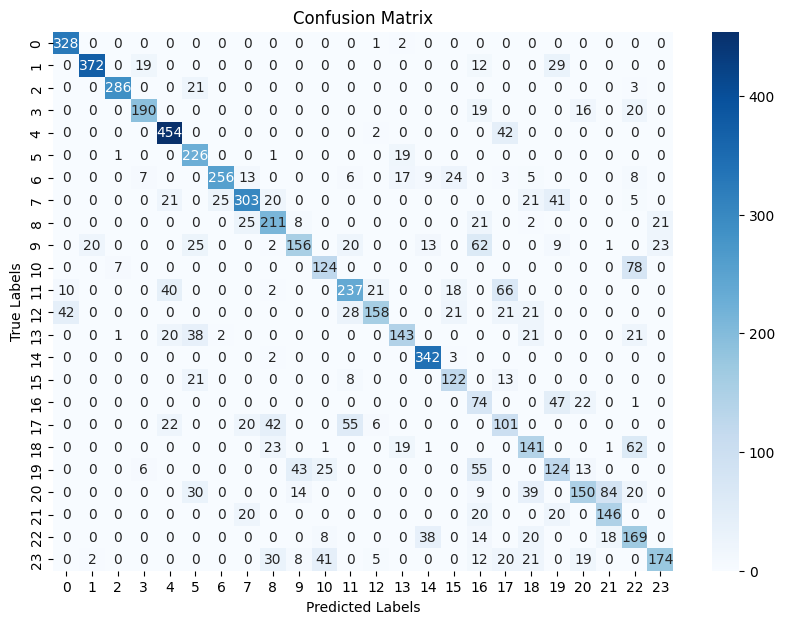

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def remap_labels(label):
    if label > 9:
        label -= 1  # Decrementation for J
    return label

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.y = torch.tensor([remap_labels(label.item()) for label in self.y], dtype=torch.long)  # Remap labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_size = 784
hidden_size = 128
num_classes = 24
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize dataset and dataloaders
train_dataset = CustomDataset('../../data/sign_mnist_train.csv')
test_dataset = CustomDataset('../../data/sign_mnist_test.csv')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate train accuracy
    correct_train = 0
    total_train = 0
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
    
    # Calculate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

# Plotting accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.tolist())
        all_preds.extend(F.softmax(outputs, dim=1).tolist())
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    accuracy = 100 * correct / total

print(f'Unique labels in y_true: {np.unique(all_labels)}')
print(f'Shape of y_score: {np.array(all_preds).shape}')

# Calculate AUC-ROC only if the shapes are expected
if len(np.unique(all_labels)) == np.array(all_preds).shape[1]:
    auc_roc = roc_auc_score(np.array(all_labels), np.array(all_preds), multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')
else:
    print("Mismatch in the number of classes and y_score columns, cannot compute AUC-ROC.")

print(f'Accuracy of the network on the test images: {accuracy} %')

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show that matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


We can observe:
- good results!
- a very good AUC-ROC, which implies that our model effectively distinguishes between all classes.
- thanks to the confusion matrix, we can understand that the letter for 16 has a lot of false predictions compared to the others. We can also see that there is significant confusion between 16 and 19.
- the graph showing accuracy as a function of epochs indicates that the training accuracy stops increasing and plateaus after the 20th epoch. Similarly, the test accuracy plateaus after the 10th epoch.

We'll try to understand why there is significant confusion between 16 and 19 :
- First : we look at distribution of classes in the dataset  
- Then : if there is class imbalance, we'll use the SMOTE method to balance, or else, we'll use data augmentation with translation, rotation...

Good to know : 
#### SMOTE (Synthetic Minority Over-sampling Technique)
 - Approche : SMOTE est une technique de suréchantillonnage qui crée de nouveaux échantillons synthétiques à partir des échantillons existants de la classe minoritaire. Ce processus est effectué dans l'espace des caractéristiques en interpolant entre des échantillons existants et leurs voisins les plus proches.

- Objectif : L'objectif principal de SMOTE est de traiter le déséquilibre des classes dans un ensemble de données d'entraînement. En créant artificiellement de nouveaux échantillons, SMOTE vise à équilibrer la distribution des classes, permettant ainsi au modèle d'apprendre de manière plus équilibrée et d'éviter le biais envers les classes majoritaires.

- Utilisation : SMOTE est particulièrement utile dans les situations où certaines classes sont significativement sous-représentées. C'est souvent le cas dans des domaines comme la détection de fraude, la médecine, ou la reconnaissance d'objets rares.

#### Augmentation des données (translation, rotation, etc.)
- Approche : L'augmentation des données par des transformations géométriques ou des modifications de l'image (telles que la rotation, la translation, le retournement, le zoom, etc.) consiste à créer de nouvelles versions d'images en modifiant les images originales. Cela peut inclure des changements d'échelle, des rotations, des ajustements de couleur, etc.

- Objectif : Le but de l'augmentation des données est de rendre le modèle plus robuste aux variations dans les données d'entrée. En exposant le modèle à des variations diverses des données existantes, l'augmentation aide à prévenir le surajustement et améliore la capacité du modèle à généraliser à partir de son ensemble de formation.

- Utilisation : Cette technique est largement utilisée dans les tâches de vision par ordinateur et de traitement des images, où la capacité à reconnaître des objets, des formes ou des caractéristiques dans différentes orientations et conditions est cruciale.

# Dividing classes up in the dataset

We are trying to see if there is class imbalance (underrepresented/overrepresented).

Distribution of classes :
label
17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: count, dtype: int64


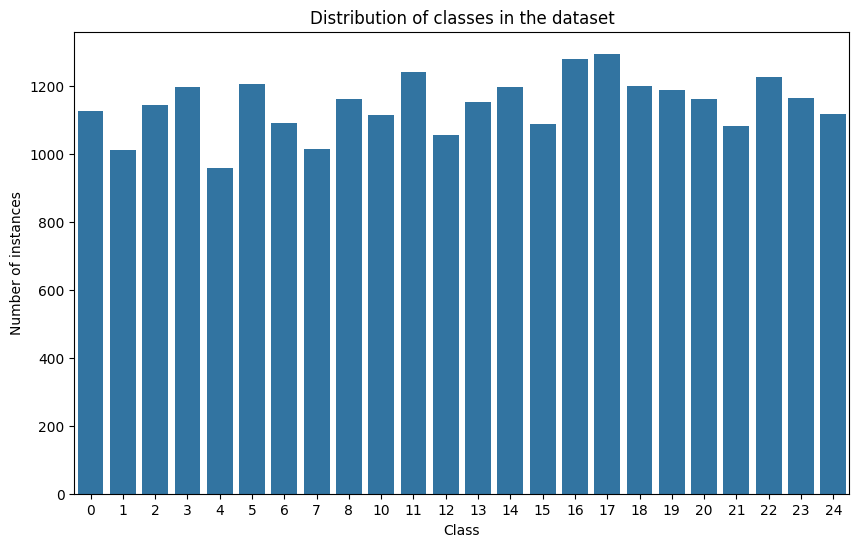

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load of data
file_path = '/Users/benjamincordebar/Desktop/2A/S8/IA-projet/SignLanguageLetterRecognitionAI/data/sign_mnist_train.csv' 
data = pd.read_csv(file_path)

# the first column contains the labels
labels = data.iloc[:, 0]    

# Count the number of instances for each class
class_distribution = labels.value_counts()

# Display the distribution of classes
print("Distribution of classes :")
print(class_distribution)

# Display the distribution of classes in a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Distribution of classes in the dataset')
plt.show()


We can observe : 
- moderate overrepresented class or moderate underrepresented class : the difference between the least represented class (class 4 with 957 instances) and the most represented class (class 17 with 1294 instances) is 337 instances. This represents a variation of about 35%, which can be considered moderately imbalanced.

To resolve this moderate imbalance : 
- performing oversampling of minority classes using SMOTE

# SMOTE method 

Distribution of classes before SMOTE:
Counter({16: 1294, 15: 1279, 10: 1241, 21: 1225, 5: 1204, 17: 1199, 3: 1196, 13: 1196, 18: 1186, 22: 1164, 8: 1162, 19: 1161, 12: 1151, 2: 1144, 0: 1126, 23: 1118, 9: 1114, 6: 1090, 14: 1088, 20: 1082, 11: 1055, 7: 1013, 1: 1010, 4: 957})


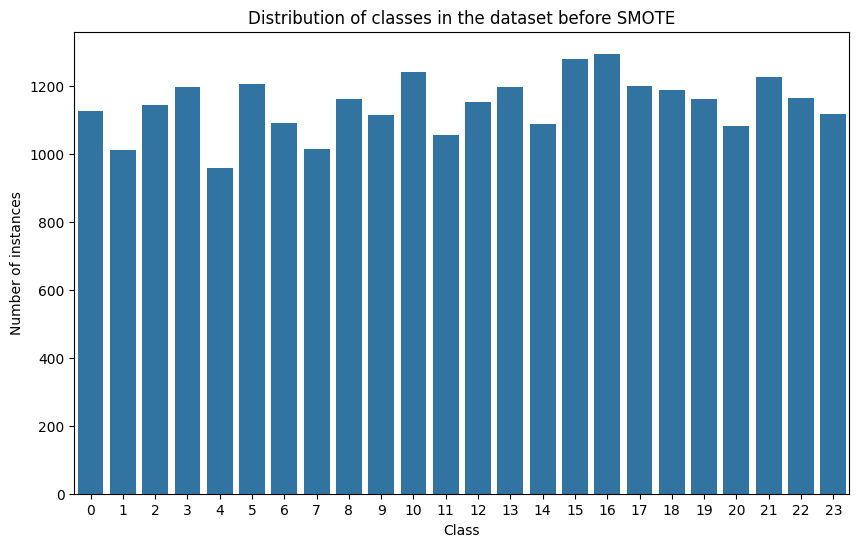

Distribution of classes after SMOTE:
Counter({3: 1294, 6: 1294, 2: 1294, 12: 1294, 15: 1294, 8: 1294, 21: 1294, 17: 1294, 9: 1294, 19: 1294, 16: 1294, 18: 1294, 20: 1294, 22: 1294, 23: 1294, 1: 1294, 11: 1294, 10: 1294, 14: 1294, 4: 1294, 0: 1294, 5: 1294, 7: 1294, 13: 1294})


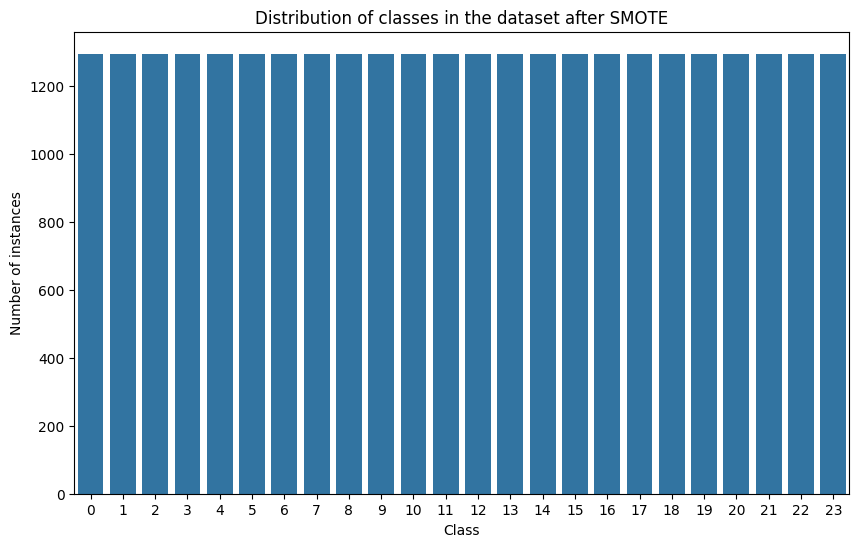

Epoch [1/50], Step [100/486], Loss: 2.7755
Epoch [1/50], Step [200/486], Loss: 2.3219
Epoch [1/50], Step [300/486], Loss: 1.8928
Epoch [1/50], Step [400/486], Loss: 1.7494
Epoch [1/50], Train Accuracy: 50.90%, Test Accuracy: 48.55%
Epoch [2/50], Step [100/486], Loss: 1.4977
Epoch [2/50], Step [200/486], Loss: 1.4928
Epoch [2/50], Step [300/486], Loss: 1.3117
Epoch [2/50], Step [400/486], Loss: 1.4959
Epoch [2/50], Train Accuracy: 63.19%, Test Accuracy: 56.25%
Epoch [3/50], Step [100/486], Loss: 1.3091
Epoch [3/50], Step [200/486], Loss: 1.0357
Epoch [3/50], Step [300/486], Loss: 1.2403
Epoch [3/50], Step [400/486], Loss: 1.0753
Epoch [3/50], Train Accuracy: 67.64%, Test Accuracy: 60.76%
Epoch [4/50], Step [100/486], Loss: 0.8358
Epoch [4/50], Step [200/486], Loss: 0.8751
Epoch [4/50], Step [300/486], Loss: 1.0001
Epoch [4/50], Step [400/486], Loss: 0.8490
Epoch [4/50], Train Accuracy: 73.26%, Test Accuracy: 62.58%
Epoch [5/50], Step [100/486], Loss: 0.8242
Epoch [5/50], Step [200/486],

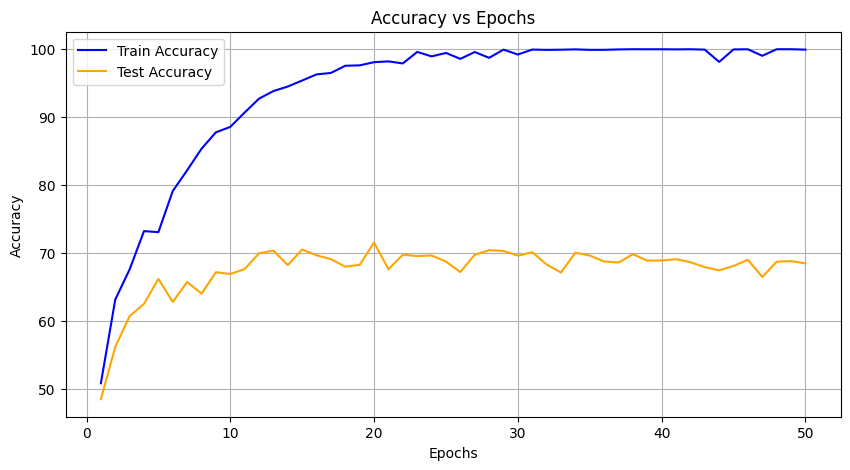

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Shape of y_score: (7172, 24)
AUC-ROC: 0.9690473037241968
Accuracy of the network on the test images: 68.51645287228109 %


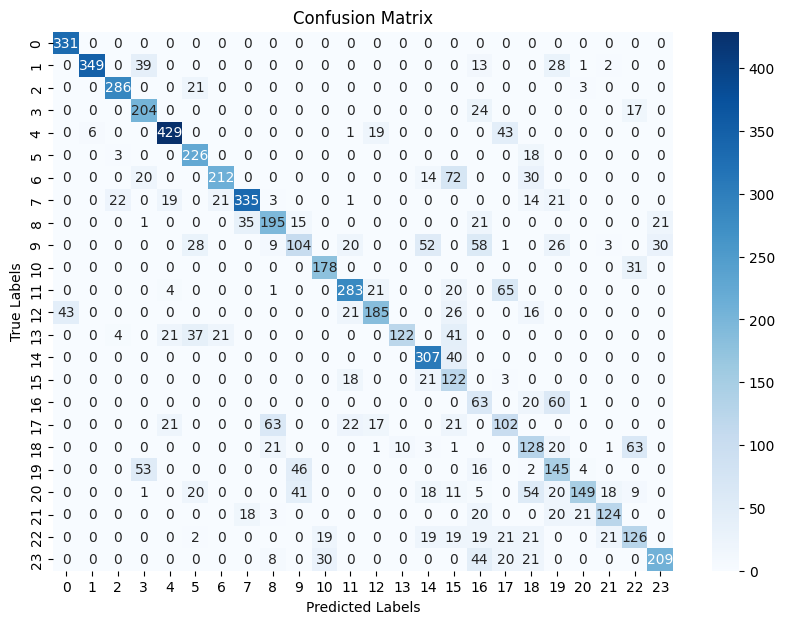

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

def remap_labels(label):
    if label > 9:
        label -= 1  # Decrementation for J
    return label

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32) / 255.0  # Normalize the images here
        self.y = torch.tensor(y, dtype=torch.long)  # Utilize already remapped labels directly
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_size = 784
hidden_size = 128
num_classes = 24
learning_rate = 0.001
batch_size = 64
epochs = 50

# Load and prepare data
train_data = pd.read_csv('/Users/benjamincordebar/Desktop/2A/S8/IA-projet/SignLanguageLetterRecognitionAI/data/sign_mnist_train.csv')
test_data = pd.read_csv('/Users/benjamincordebar/Desktop/2A/S8/IA-projet/SignLanguageLetterRecognitionAI/data/sign_mnist_test.csv')

X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].apply(remap_labels).values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].apply(remap_labels).values

# Count the number of instances for each class before SMOTE
class_distribution = Counter(y_train)  # Count the number of instances for each class with Counter

# Display the distribution of classes before SMOTE
print("Distribution of classes before SMOTE:")
print(class_distribution)

# Display the distribution of classes in a bar plot before SMOTE
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Distribution of classes in the dataset before SMOTE')
plt.show()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Count the number of instances for each class after SMOTE
class_distribution = Counter(y_train_resampled)  # Count the number of instances for each class with Counter

# Display the distribution of classes after SMOTE
print("Distribution of classes after SMOTE:")
print(class_distribution)

# Display the distribution of classes in a bar plot after SMOTE
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Distribution of classes in the dataset after SMOTE')
plt.show()

# Initialize dataset and dataloaders
train_dataset = CustomDataset(X_train_resampled, y_train_resampled)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate train accuracy
    correct_train = 0
    total_train = 0
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
    
    # Calculate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

# Plotting accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.tolist())
        all_preds.extend(F.softmax(outputs, dim=1).tolist())
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    accuracy = 100 * correct / total

print(f'Unique labels in y_true: {np.unique(all_labels)}')
print(f'Shape of y_score: {np.array(all_preds).shape}')

# Calculate AUC-ROC only if the shapes are expected
if len(np.unique(all_labels)) == np.array(all_preds).shape[1]:
    auc_roc = roc_auc_score(np.array(all_labels), np.array(all_preds), multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')
else:
    print("Mismatch in the number of classes and y_score columns, cannot compute AUC-ROC.")

print(f'Accuracy of the network on the test images: {accuracy} %')

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show that matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Adding new hidden layers and increasing the number of neurons in them 

Epoch [1/50], Step [100/429], Loss: 2.8922
Epoch [1/50], Step [200/429], Loss: 2.1662
Epoch [1/50], Step [300/429], Loss: 1.8655
Epoch [1/50], Step [400/429], Loss: 1.7134
Epoch [1/50], Train Accuracy: 44.46%, Test Accuracy: 40.21%
Epoch [2/50], Step [100/429], Loss: 1.4510
Epoch [2/50], Step [200/429], Loss: 1.4861
Epoch [2/50], Step [300/429], Loss: 1.7531
Epoch [2/50], Step [400/429], Loss: 1.4860
Epoch [2/50], Train Accuracy: 53.90%, Test Accuracy: 46.43%
Epoch [3/50], Step [100/429], Loss: 1.2109
Epoch [3/50], Step [200/429], Loss: 1.0412
Epoch [3/50], Step [300/429], Loss: 1.1586
Epoch [3/50], Step [400/429], Loss: 1.0958
Epoch [3/50], Train Accuracy: 63.55%, Test Accuracy: 54.06%
Epoch [4/50], Step [100/429], Loss: 1.1570
Epoch [4/50], Step [200/429], Loss: 0.9488
Epoch [4/50], Step [300/429], Loss: 0.7377
Epoch [4/50], Step [400/429], Loss: 0.8535
Epoch [4/50], Train Accuracy: 70.97%, Test Accuracy: 60.07%
Epoch [5/50], Step [100/429], Loss: 0.8131
Epoch [5/50], Step [200/429],

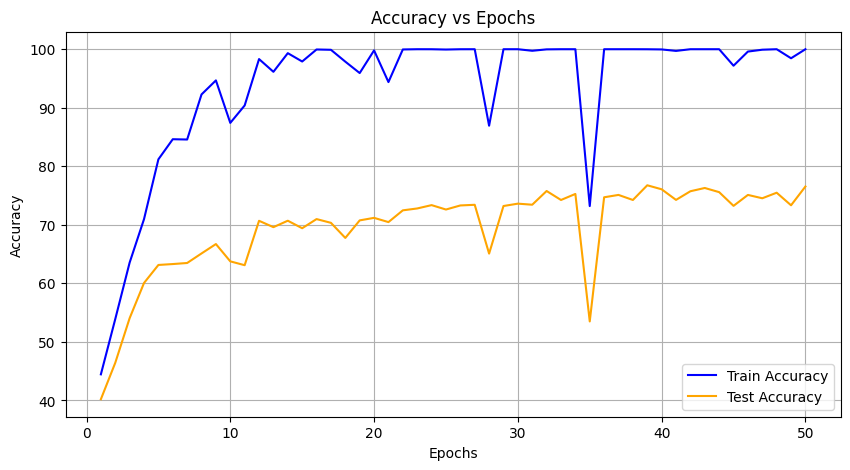

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Shape of y_score: (7172, 24)
AUC-ROC: 0.9829574045944591
Accuracy of the network on the test images: 76.54768544339096 %


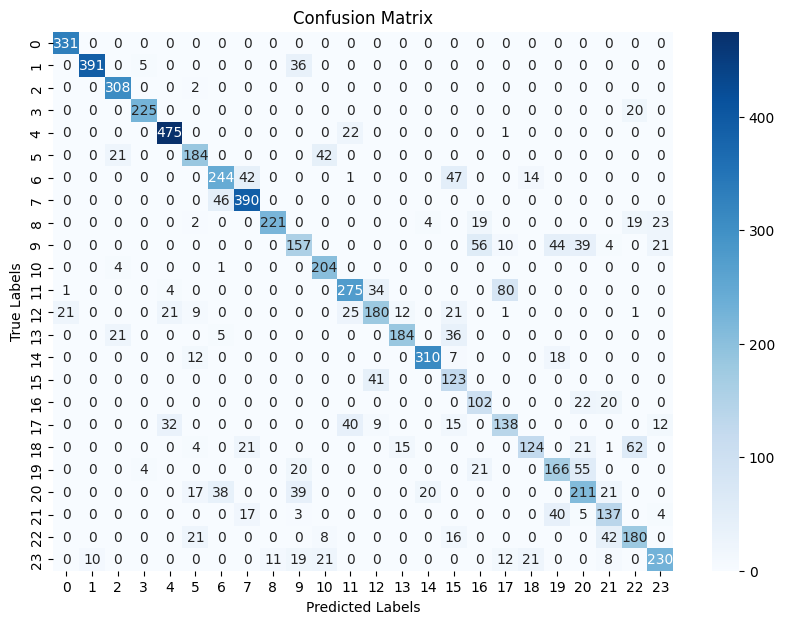

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def remap_labels(label):
    if label > 9:
        label -= 1  # Decrementation for J
    return label

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.y = torch.tensor([remap_labels(label.item()) for label in self.y], dtype=torch.long)  # Remap labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

# Hyperparameters
input_size = 784
hidden_sizes = [256, 128, 64]  # Augmented number of neurons and hidden layers
num_classes = 24
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize dataset and dataloaders
train_dataset = CustomDataset('../../data/sign_mnist_train.csv')
test_dataset = CustomDataset('../../data/sign_mnist_test.csv')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate train accuracy
    correct_train = 0
    total_train = 0
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
    
    # Calculate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

# Plotting accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.tolist())
        all_preds.extend(F.softmax(outputs, dim=1).tolist())
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    accuracy = 100 * correct / total

print(f'Unique labels in y_true: {np.unique(all_labels)}')
print(f'Shape of y_score: {np.array(all_preds).shape}')

# Calculate AUC-ROC only if the shapes are expected
if len(np.unique(all_labels)) == np.array(all_preds).shape[1]:
    auc_roc = roc_auc_score(np.array(all_labels), np.array(all_preds), multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')
else:
    print("Mismatch in the number of classes and y_score columns, cannot compute AUC-ROC.")

print(f'Accuracy of the network on the test images: {accuracy} %')

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show that matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Again, adding new hidden layers and increasing the number of neurons in them 

Epoch [1/50], Step [100/429], Loss: 3.1558
Epoch [1/50], Step [200/429], Loss: 2.9029
Epoch [1/50], Step [300/429], Loss: 2.6510
Epoch [1/50], Step [400/429], Loss: 2.2105
Epoch [1/50], Train Accuracy: 30.09%, Test Accuracy: 27.68%
Epoch [2/50], Step [100/429], Loss: 1.9470
Epoch [2/50], Step [200/429], Loss: 1.6789
Epoch [2/50], Step [300/429], Loss: 2.0661
Epoch [2/50], Step [400/429], Loss: 1.4740
Epoch [2/50], Train Accuracy: 43.09%, Test Accuracy: 39.03%
Epoch [3/50], Step [100/429], Loss: 1.3489
Epoch [3/50], Step [200/429], Loss: 1.4126
Epoch [3/50], Step [300/429], Loss: 1.3761
Epoch [3/50], Step [400/429], Loss: 1.5144
Epoch [3/50], Train Accuracy: 53.01%, Test Accuracy: 43.98%
Epoch [4/50], Step [100/429], Loss: 1.3966
Epoch [4/50], Step [200/429], Loss: 1.2360
Epoch [4/50], Step [300/429], Loss: 1.2509
Epoch [4/50], Step [400/429], Loss: 1.0159
Epoch [4/50], Train Accuracy: 59.58%, Test Accuracy: 44.26%
Epoch [5/50], Step [100/429], Loss: 0.9803
Epoch [5/50], Step [200/429],

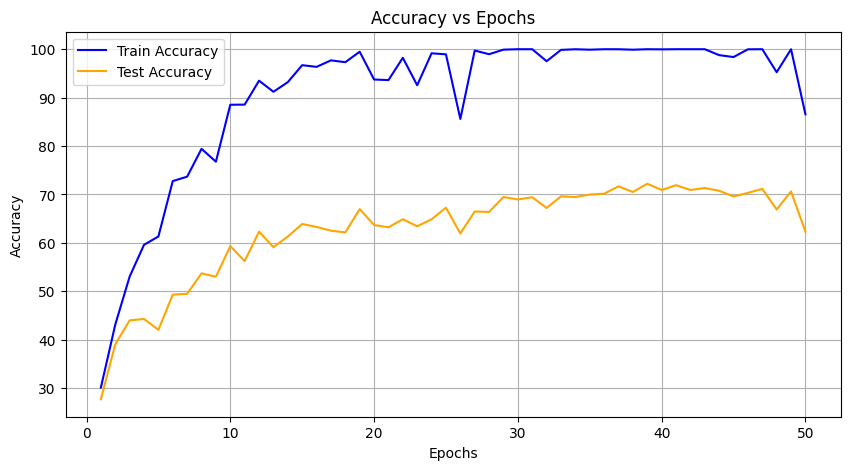

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Shape of y_score: (7172, 24)
AUC-ROC: 0.9665453382571871
Accuracy of the network on the test images: 62.31176798661461 %


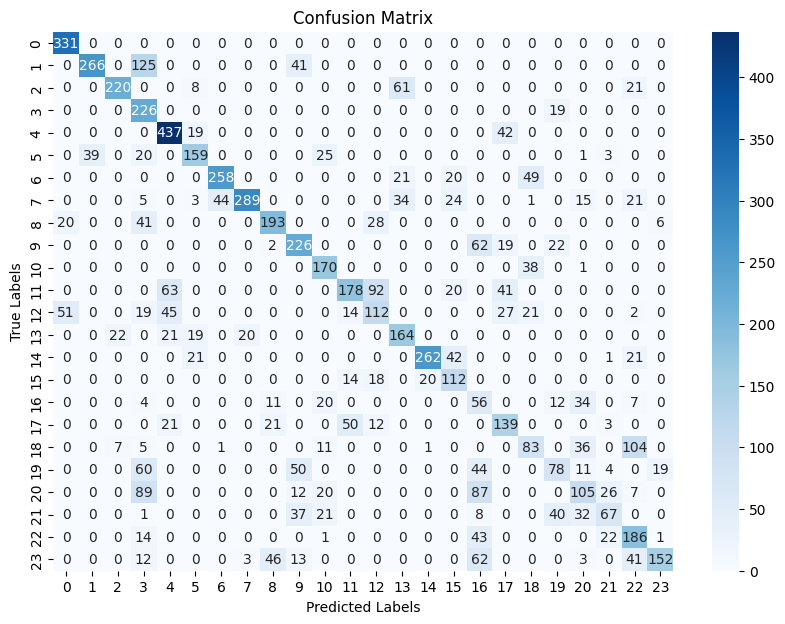

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def remap_labels(label):
    if label > 9:
        label -= 1  # Decrementation for J
    return label

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.y = torch.tensor([remap_labels(label.item()) for label in self.y], dtype=torch.long)  # Remap labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

# Hyperparameters
input_size = 784
hidden_sizes = [512, 256, 128, 64, 32]  # Increased number of neurons and hidden layers
num_classes = 24
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize dataset and dataloaders
train_dataset = CustomDataset('../../data/sign_mnist_train.csv')
test_dataset = CustomDataset('../../data/sign_mnist_test.csv')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate train accuracy
    correct_train = 0
    total_train = 0
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
    
    # Calculate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

# Plotting accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.tolist())
        all_preds.extend(F.softmax(outputs, dim=1).tolist())
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    accuracy = 100 * correct / total

print(f'Unique labels in y_true: {np.unique(all_labels)}')
print(f'Shape of y_score: {np.array(all_preds).shape}')

# Calculate AUC-ROC only if the shapes are expected
if len(np.unique(all_labels)) == np.array(all_preds).shape[1]:
    auc_roc = roc_auc_score(np.array(all_labels), np.array(all_preds), multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')
else:
    print("Mismatch in the number of classes and y_score columns, cannot compute AUC-ROC.")

print(f'Accuracy of the network on the test images: {accuracy} %')

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show that matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/50], Step [100/429], Loss: 3.1717
Epoch [1/50], Step [200/429], Loss: 2.9396
Epoch [1/50], Step [300/429], Loss: 2.6954
Epoch [1/50], Step [400/429], Loss: 2.5941
Epoch [1/50], Train Accuracy: 29.21%, Test Accuracy: 26.31%
Epoch [2/50], Step [100/429], Loss: 2.3596
Epoch [2/50], Step [200/429], Loss: 2.0592
Epoch [2/50], Step [300/429], Loss: 2.1026
Epoch [2/50], Step [400/429], Loss: 1.8842
Epoch [2/50], Train Accuracy: 32.95%, Test Accuracy: 22.46%
Epoch [3/50], Step [100/429], Loss: 1.9368
Epoch [3/50], Step [200/429], Loss: 1.7816
Epoch [3/50], Step [300/429], Loss: 1.6271
Epoch [3/50], Step [400/429], Loss: 1.6304
Epoch [3/50], Train Accuracy: 38.73%, Test Accuracy: 36.53%
Epoch [4/50], Step [100/429], Loss: 1.6216
Epoch [4/50], Step [200/429], Loss: 1.6436
Epoch [4/50], Step [300/429], Loss: 1.3972
Epoch [4/50], Step [400/429], Loss: 1.4911
Epoch [4/50], Train Accuracy: 38.68%, Test Accuracy: 34.10%
Epoch [5/50], Step [100/429], Loss: 1.2720
Epoch [5/50], Step [200/429],

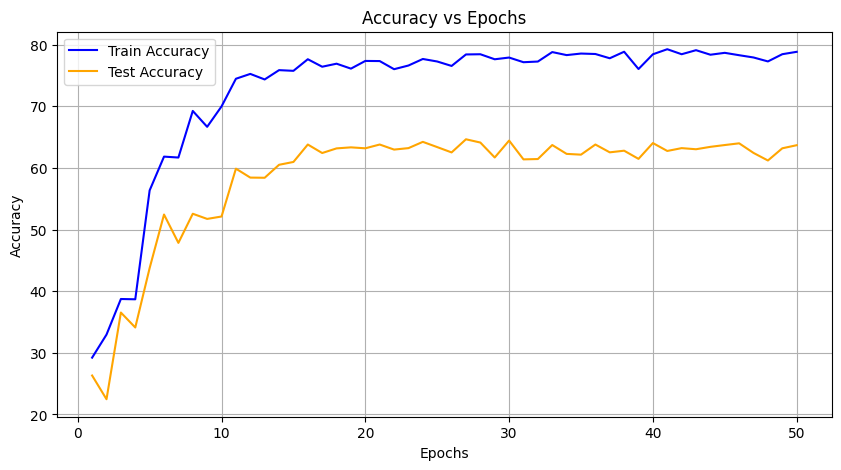

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Shape of y_score: (7172, 24)
AUC-ROC: 0.9718989253851525
Accuracy of the network on the test images: 63.69213608477412 %


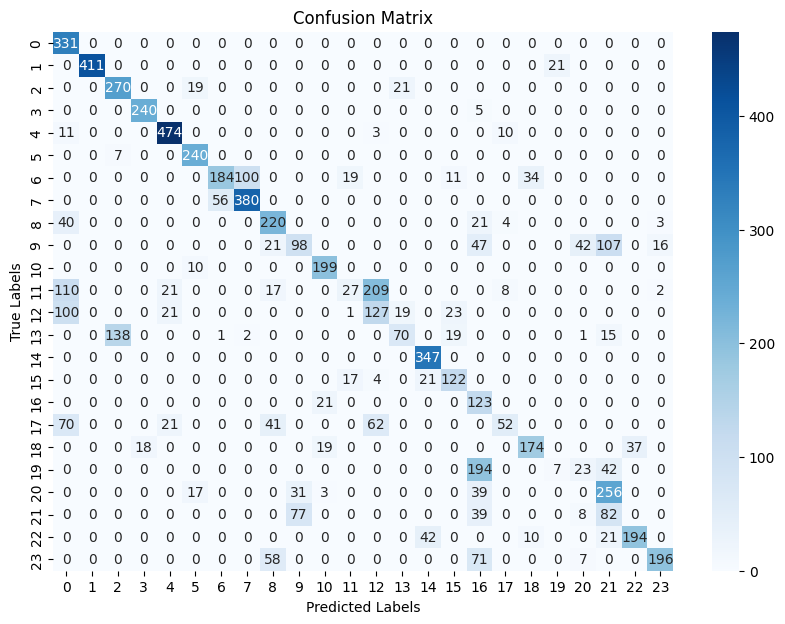

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def remap_labels(label):
    if label > 9:
        label -= 1  # Decrementation for J
    return label

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.y = torch.tensor([remap_labels(label.item()) for label in self.y], dtype=torch.long)  # Remap labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.bn4 = nn.BatchNorm1d(hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.bn5 = nn.BatchNorm1d(hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc5(out)
        out = self.bn5(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc6(out)
        return out

# Hyperparameters
input_size = 784
hidden_sizes = [512, 256, 128, 64, 32]  # Increased number of neurons and hidden layers
num_classes = 24
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize dataset and dataloaders
train_dataset = CustomDataset('../../data/sign_mnist_train.csv')
test_dataset = CustomDataset('../../data/sign_mnist_test.csv')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
model = MLP(input_size, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate train accuracy
    correct_train = 0
    total_train = 0
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
    
    # Calculate test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
    scheduler.step()

# Plotting accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.tolist())
        all_preds.extend(F.softmax(outputs, dim=1).tolist())
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    accuracy = 100 * correct / total

print(f'Unique labels in y_true: {np.unique(all_labels)}')
print(f'Shape of y_score: {np.array(all_preds).shape}')

# Calculate AUC-ROC only if the shapes are expected
if len(np.unique(all_labels)) == np.array(all_preds).shape[1]:
    auc_roc = roc_auc_score(np.array(all_labels), np.array(all_preds), multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')
else:
    print("Mismatch in the number of classes and y_score columns, cannot compute AUC-ROC.")

print(f'Accuracy of the network on the test images: {accuracy} %')

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show that matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Despite our efforts to manage overfitting through the use of dropout regularization and batch normalization, as well as dynamically adjusting the learning rate using a scheduler, the results obtained are less satisfactory than expected. This highlights one of the limitations of the multilayer perceptron (MLP) model. While MLPs are powerful for many tasks, they may not be sufficient to capture complex relationships in more advanced data. More sophisticated network architectures such as Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs) may be required to improve performance on more complex tasks.